In [ ]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from src.models import *
from src.dataloader import *
from src.utils import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pickle
import json

## Train and Val

In [2]:
data_dir = '/home/jupyter/data/'

In [3]:
args = {'tigge_dir':data_dir + f'tigge/32km/',
    'tigge_vars':['total_precipitation_ens10','total_column_water_ens10'],#, '2m_temperature', 'convective_available_potential_energy', 'convective_inhibition'],
    'mrms_dir':data_dir + f'mrms/4km/RadarOnly_QPE_06H/',
    'rq_fn':data_dir + f'mrms/4km/RadarQuality.nc',
#     'const_fn':data_dir + 'tigge/32km/constants.nc',
#     'const_vars':['orog', 'lsm'],
    'data_period':('2018-01', '2019-12'),
    'val_days':5,
    'split':'train',
#     'pure_sr_ratio':8, 
#     'tp_log':0.01, 
    'ensemble_mode':'random',
    'pad_tigge':10,
    'pad_tigge_channel': True
    }

dataset_name = 'ensemble_tp_extra_vars_TCW_x10_padded_10_channel'

In [4]:
ds_train = TiggeMRMSDataset(**args)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [5]:
pickle.dump(ds_train, open(data_dir + f"saved_datasets/traindataset_{dataset_name}.pkl", "wb"))
pickle.dump(args, open(data_dir + f"saved_datasets/traindataset_{dataset_name}_args.pkl", "wb"))

In [6]:
val_args = args
val_args['maxs'] = ds_train.maxs
val_args['mins'] = ds_train.mins
val_args['split'] = 'valid'

ds_valid = TiggeMRMSDataset(**val_args)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [7]:
pickle.dump(ds_valid, open(data_dir + f"saved_datasets/validdataset_{dataset_name}.pkl", "wb"))
pickle.dump(val_args, open(data_dir + f"saved_datasets/validdataset_{dataset_name}_args.pkl", "wb"))

In [8]:
test_args = args
test_args['maxs'] = ds_train.maxs
test_args['mins'] = ds_train.mins
test_args.pop('val_days')
test_args.pop('split')
test_args['first_days'] = 5
test_args['data_period'] = ('2020-01', '2020-12')
test_dataset_name = dataset_name + f"_first_days_{test_args['first_days']}"

ds_test = TiggeMRMSDataset(**test_args)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [9]:
pickle.dump(ds_test, open(data_dir + f"saved_datasets/testdataset_{test_dataset_name}.pkl", "wb"))
pickle.dump(test_args, open(data_dir + f"saved_datasets/testdataset_{test_dataset_name}_args.pkl", "wb"))

# Broad field of vision

In [18]:
DATADRIVE = '/datadrive_ssd/'

In [19]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2019-12'),
    val_days=5,
    split='train',
    pure_sr_ratio=None, 
    tp_log=0.01, 
    pad_tigge=24
)

In [20]:
ds_valid = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2019-12'),
    val_days=5,
    split='valid',
    mins=ds_train.mins,
    maxs=ds_train.maxs,
    pure_sr_ratio=None,
    tp_log= 0.01,
    pad_tigge=24
)

/anaconda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


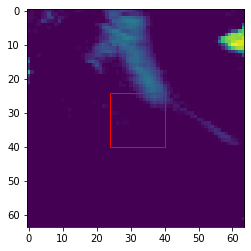

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


fig, ax = plt.subplots()
ax.imshow(ds_train[3][0][0])
rect = patches.Rectangle((24, 24), 16, 16, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [7]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(), len(ds_train))
sampler_valid = torch.utils.data.WeightedRandomSampler(ds_valid.compute_weights(), len(ds_valid))

In [24]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=16, sampler=sampler_train, num_workers=6)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=16, sampler=sampler_valid, num_workers=6)

In [25]:
len(ds_train), len(dl_train)

(16674, 1043)

In [26]:
pickle.dump(dl_train, open(DATADRIVE+"saved_datasets/trainloader_single_forecast_only_log_trans_full_padded_24.pkl", "wb"))
pickle.dump(dl_valid, open(DATADRIVE+"saved_datasets/validloader_single_forecast_only_log_trans_full_padded_24.pkl", "wb"))
pickle.dump(ds_train, open(DATADRIVE+"saved_datasets/traindataset_single_forecast_only_log_trans_full_padded_24.pkl", "wb"))
pickle.dump(ds_valid, open(DATADRIVE+"saved_datasets/validdataset_single_forecast_only_log_trans_full_padded_24.pkl", "wb"))

## Test

In [5]:
# ds_train = pickle.load(open("/home/jupyter/data/saved_datasets/traindataset_ensemble_forecast_x10_random_log_trans_full.pkl", "rb"))

In [6]:
# ds_test = TiggeMRMSDataset(
#     tigge_dir=f'/home/jupyter/data/tigge/32km/',
#     tigge_vars=['total_precipitation_ens10'],
#     mrms_dir=f'/home/jupyter/data/mrms/4km/RadarOnly_QPE_06H/',
#     rq_fn=f'/home/jupyter/data/mrms/4km/RadarQuality.nc',
# #     const_fn='/home/jupyter/data/tigge/32km/constants.nc',
# #     const_vars=['orog', 'lsm'],
#     data_period=('2020-01', '2020-12'),
#     mins=ds_train.mins,
#     maxs=ds_train.maxs,
#     first_days=5,
#     pure_sr_ratio=None, 
#     tp_log=0.01, 
#     pad_tigge=0, 
#     ensemble_mode='random'
# )

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [7]:
# pickle.dump(ds_test, open("/home/jupyter/data/saved_datasets/testdataset_single_forecast_only_log_trans_full_padded_24.pkl", "wb"))
# pickle.dump(ds_test, open("/home/jupyter/data/saved_datasets/testdataset_ensemble_forecast_x10_log_trans_sample.pkl", "wb"))
# pickle.dump(ds_test, open("/home/jupyter/data/saved_datasets/testdataset_single_forecast_only_log_trans_sample.pkl", "wb"))
pickle.dump(ds_test, open("/home/jupyter/data/saved_datasets/testdataset_ensemble_forecast_x10_random_log_trans_sample.pkl", "wb"))

In [17]:
a = torch.from_numpy(np.random.normal(size=(1,256,1,1)))
a.shape

torch.Size([1, 256, 1, 1])

In [19]:
b= torch.from_numpy(np.random.normal(size=(1,256,1,1)))

In [14]:
# ds_test = pickle.load(open("/home/jupyter/data/saved_datasets/testdataset_single_forecast_only_log_trans_sample.pkl", "rb"))
ds_test = pickle.load(open("/home/jupyter/data/saved_datasets/traindataset_single_forecast_tp_extra_vars_TCW-T-CAPE-CIN_log_trans.pkl", "rb"))

In [15]:
# len(ds_test) - 669*64

-1596

In [6]:
3960/128

30.9375

In [5]:
ds = pickle.load(open("/home/jupyter/data/saved_datasets/traindataset_single_forecast_orog_lsm_log_trans_full.pkl","rb"))

(3, 16, 16)